## PLAsTiCC v2.0 alert simulation 

This is a demo of how we can add catalog simulations to LSST alerts in avro forma, which the Rubin project is using. 

Follow the README of this repository and then the README of `alert_packet` for setup. This involves installing `alert_packet` in some way.

This notebook is based on the examples and codes in `alert_packet` :https://github.com/lsst/alert_packet

In [2]:
import lsst.alert.packet

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import os
from copy import copy

In [4]:
import json
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.time import Time
import glob
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

### These functions will enable us to plot the output from our avro object

In [5]:
def make_dataframe(packet):
    df = pd.DataFrame(packet['diaSource'], index=[0])
    df_prv = pd.DataFrame(packet['prvDiaSources'])
    return pd.concat([df,df_prv], ignore_index=True)

def plot_lightcurve(dflc, days_ago=True):
    
    filter_color = {'g':'green', 'r':'red', 'u':'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.midPointTai - now
        xlabel = 'Days Ago'
    else:
        t = dflc.midPointTai
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.filterName == fid) & ~dflc.psFlux.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'apFlux'], dflc.loc[w,'apFluxErr'],fmt='.',color=color)
        #wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        #if np.sum(wnodet):
         #   plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')

### Let's read in the schema from the Rubin alert.packet 

In [6]:
schema = lsst.alert.packet.Schema.from_file()

If you clone the repository `alert_packet` this is the location of the alert.json file.

In [7]:
path = Path('../../alert_packet/python/lsst/alert/packet/schema/4/0/sample_data/')
with open(path/'alert.json') as f:
    alert_data = json.load(f)

### What does the alert data schema look like?
It has one diaSource object for the current epoch

In [8]:
alert_data['diaSource']

{'diaSourceId': 281323062375219200,
 'ccdVisitId': 111111,
 'midPointTai': 1480360995,
 'filterName': 'r',
 'programId': 1,
 'ra': 351.570546978,
 'decl': 0.126243049656,
 'raSigma': 0.00028,
 'declSigma': 0.00028,
 'ra_decl_Cov': 0.00029,
 'x': 112.1,
 'y': 121.1,
 'xSigma': 1.2,
 'ySigma': 1.1,
 'x_y_Cov': 1.2,
 'apFlux': 1241.0,
 'apFluxErr': 12.0,
 'snr': 41.1,
 'psFlux': 1241.0,
 'psFluxErr': 12.0,
 'flags': 0}

 The previous diaSources for this diaObject are also nested in the schema

In [9]:
alert_data['prvDiaSources']

[{'diaSourceId': 281323062375219198,
  'ccdVisitId': 111111,
  'midPointTai': 1480360995,
  'filterName': 'r',
  'programId': 1,
  'ra': 351.570546978,
  'decl': 0.126243049656,
  'raSigma': 0.00028,
  'declSigma': 0.00028,
  'ra_decl_Cov': 0.00029,
  'x': 112.1,
  'y': 121.1,
  'xSigma': 1.2,
  'ySigma': 1.1,
  'x_y_Cov': 1.2,
  'apFlux': 1241.0,
  'apFluxErr': 12.0,
  'snr': 41.1,
  'psFlux': 1241.0,
  'psFluxErr': 12.0,
  'flags': 0},
 {'diaSourceId': 281323062375219199,
  'ccdVisitId': 111111,
  'midPointTai': 1480360995,
  'filterName': 'r',
  'programId': 1,
  'ra': 351.570546978,
  'decl': 0.126243049656,
  'raSigma': 0.00028,
  'declSigma': 0.00028,
  'ra_decl_Cov': 0.00029,
  'x': 112.1,
  'y': 121.1,
  'xSigma': 1.2,
  'ySigma': 1.1,
  'x_y_Cov': 1.2,
  'apFlux': 1241.0,
  'apFluxErr': 12.0,
  'snr': 41.1,
  'psFlux': 1241.0,
  'psFluxErr': 12.0,
  'flags': 0}]

This is just a dictionary: You can write some code to read the data from SNANA and write it to the values of the correct keys

In [10]:
# Pull off the first record to overwrite with SNANA information
diasrc = alert_data['prvDiaSources'][0]

## Taking an SNANA file and porting information to alert
We will pull off models from the PLAsTiCC v2.0 DDF simulation, and assign the info to the alert packet. Note that we are adding information that isn't in the defined schema for this round.
Example:

In [11]:
savedir='/global/cscratch1/sd/rhlozek/alerts/plasticc_alerts/Examples'
os.chdir(savedir)
retval = os.getcwd()
simdir='/global/cscratch1/sd/kessler/SNANA_LSST_SIM/GSN_LSST_DDF/'
os.chdir(simdir)
modelname = glob.glob('*')
os.chdir(retval)
print(modelname)

['GSN_LSST_DDF_MODEL06_uLens-Single-GenLens', 'GSN_LSST_DDF_MODEL62_SNIbc-Templates', 'GSN_LSST_DDF_MODEL52_SNIax', 'GSN_LSST_DDF_MODEL99_ILOT', 'GSN_LSST_DDF_MODEL99_PISN', 'GSN_LSST_DDF_MODEL99_uLens-Binary', 'GSN_LSST_DDF_MODEL67_SNIa-91bg', 'GSN_LSST_DDF_MODEL42_SNIIn', 'GSN_LSST_DDF_MODEL42_SNII-NMF', 'GSN_LSST_DDF_MODEL42_SNII-Templates', 'GSN_LSST_DDF_MODEL06_uLens-Single_PyLIMA', 'GSN_LSST_DDF_MODEL64_KN_K17', 'GSN_LSST_DDF_MODEL64_KN_B19', 'GSN_LSST_DDF_MODEL88_AGN', 'GSN_LSST_DDF_MODEL65_Mdwarf', 'GSN_LSST_DDF_MODEL42_V19_CC+HostXT', 'GSN_LSST_DDF_MODEL53_MIRA', 'GSN_LSST_DDF_MODEL15_TDE', 'GSN_LSST_DDF_MODEL95_SLSN-I', 'GSN_LSST_DDF_MODEL92_RRL', 'GSN_LSST_DDF_MODEL16_EB', 'GSN_LSST_DDF_MODEL99_CART', 'GSN_LSST_DDF_MODEL62_SNIbc-MOSFIT', 'GSN_LSST_DDF_MODEL90_SNIa-SALT2']


GSN_LSST_DDF_MODEL06_uLens-Single-GenLens
This model GSN_LSST_DDF_MODEL06_uLens-Single-GenLens seems to have no data
GSN_LSST_DDF_MODEL62_SNIbc-Templates
This model GSN_LSST_DDF_MODEL62_SNIbc-Templates seems to have no data
GSN_LSST_DDF_MODEL52_SNIax
This model GSN_LSST_DDF_MODEL52_SNIax seems to have no data
GSN_LSST_DDF_MODEL99_ILOT
This model GSN_LSST_DDF_MODEL99_ILOT seems to have no data
GSN_LSST_DDF_MODEL99_PISN
This model GSN_LSST_DDF_MODEL99_PISN seems to have no data
GSN_LSST_DDF_MODEL99_uLens-Binary
This model GSN_LSST_DDF_MODEL99_uLens-Binary seems to have no data
GSN_LSST_DDF_MODEL67_SNIa-91bg
This model GSN_LSST_DDF_MODEL67_SNIa-91bg seems to have no data
GSN_LSST_DDF_MODEL42_SNIIn
This model GSN_LSST_DDF_MODEL42_SNIIn seems to have no data
GSN_LSST_DDF_MODEL42_SNII-NMF
This model GSN_LSST_DDF_MODEL42_SNII-NMF seems to have no data
GSN_LSST_DDF_MODEL42_SNII-Templates
This model GSN_LSST_DDF_MODEL42_SNII-Templates seems to have no data
GSN_LSST_DDF_MODEL06_uLens-Single_PyLI

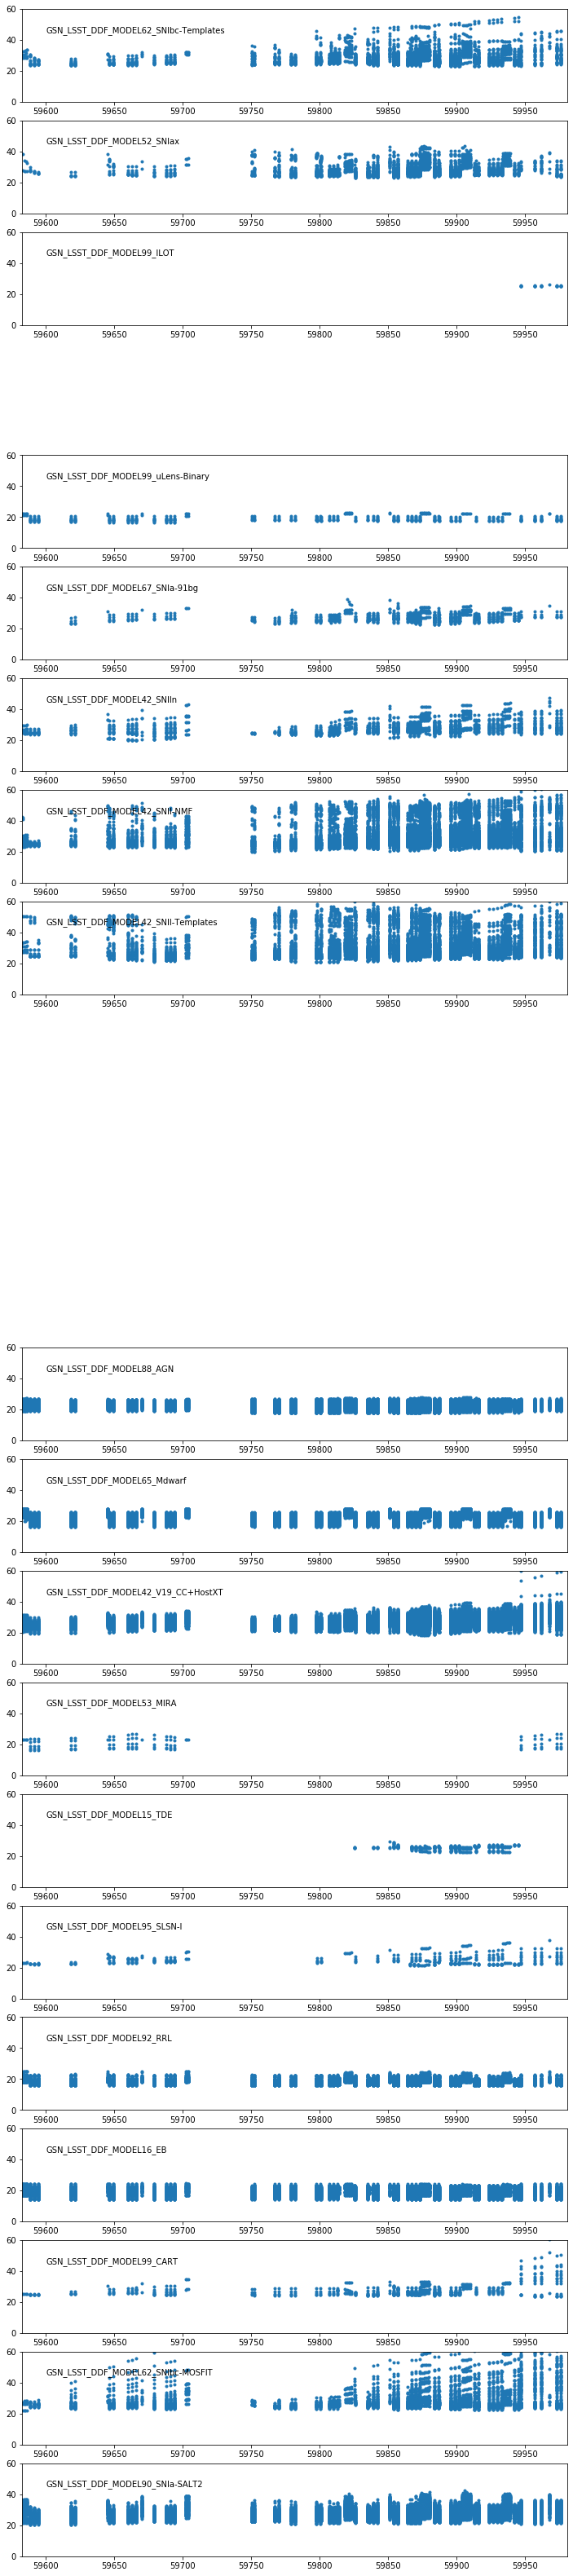

In [30]:
fig = plt.figure(figsize=(12,60))
number_of_subplots=len(modelname)
keep = np.zeros(len(modelname))

path = Path('/global/cscratch1/sd/rhlozek/alerts/alert_packet/python/lsst/alert/packet/schema/4/0/sample_data/')
with open(path/'alert.json') as f:
    alert_data_orig = json.load(f)

for countm,name in enumerate(modelname):
    print(name)
    # Open the photometry file and the header files
    name_head=simdir+name+'/'+'GSN_LSST_DDF_NONIaMODEL0-0001_HEAD.FITS.gz'
    name_phot=simdir+name+'/'+'GSN_LSST_DDF_NONIaMODEL0-0001_PHOT.FITS.gz'
    head = fits.open(name_head)
    head_cols=head[1].columns
    #print(head_cols)
    phot = fits.open(name_phot)
    phot_cols=phot[1].columns
    #print(phot_cols)
    #plt.close('all')
    
    
    # now take header information
    mjd = phot[1].data['MJD']
    mag = phot[1].data['SIM_MAGOBS']
#     time=Time(mjd[0], format='mjd')
#     newtime=time.to_value('unix_tai')
#     print(newtime)
    try:
        bound = np.where(mjd==-777)[0][0]-1
        #print(bound, countm)
        ax1 = plt.subplot(number_of_subplots,1,countm)
        plt.plot(mjd, mag,'.')
        plt.text(59600,45, '%s'%name)
        plt.axis([59582.3282,59582.3282+399, 0,60])
        filt = phot[1].data['BAND'][0:bound]
        mag = phot[1].data['SIM_MAGOBS'][0:bound]
        ginds = np.where(phot[1].data['BAND'][0:bound]=='g')
        zinds = np.where(phot[1].data['BAND'][0:bound]=='z')
        fluxcal =  phot[1].data['FLUXCAL'][0:bound]
        fluxcalerr =  phot[1].data['FLUXCALERR'][0:bound]
        snr = fluxcal/fluxcalerr
        mjd=mjd[0:bound]
        #photflag= phot[1].data['PHOTFLAG'][0:bound]
        #photprob = phot[1].data['PHOTPROB'][0:bound]
        #zeropt = phot[1].data['ZEROPT'][0:bound]
        #zeropt_err = phot[1].data['ZEROPT_ERR'][0:bound]
        #print(photflag)
    
        # copy the original alert data and clear all old sources
        alert = copy(alert_data_orig)
        diasrc = alert_data_orig['prvDiaSources'][0]
        my_diasrc = copy(diasrc)
        alert = copy(alert_data_orig)
        #print(alert['prvDiaSources'])
        #print(huh)
        alert['prvDiaSources'].clear()
        #print(alert['prvDiaSources'])
        my_diasrc['diaSourceId'] = np.int(28132306237521+1000*np.random())
        my_diasrc['midPointTai'] = mjd[0]
#         , format='mjd').to_value('tai',subfmt='decimal')
#         print(my_diasrc['midPointTai'])
        my_diasrc['filterName'] = filt[0]
        my_diasrc['snr'] = snr[0]
        my_diasrc['apFlux'] = fluxcal[0]
        my_diasrc['apFluxErr'] = fluxcalerr[0]
        my_diasrc['ra'] = head[1].data['RA']
        my_diasrc['dec'] = head[1].data['DEC']
        my_diasrc['nobs'] = head[1].data['NOBS']
        my_diasrc['mwebv'] = head[1].data['MWEBV']
        my_diasrc['mwebv_err'] = head[1].data['MWEBV_ERR']
        my_diasrc['z_final'] = head[1].data['REDSHIFT_FINAL']
        my_diasrc['z_final_err'] = head[1].data['REDSHIFT_FINAL_ERR']
        my_diasrc['hostgal_photoz']=head[1].data['HOSTGAL_PHOTOZ']
        my_diasrc['hostgal_photoz_err']=head[1].data['HOSTGAL_PHOTOZ_ERR']
        my_diasrc['hostgal_ra'] = head[1].data['HOSTGAL_RA']
        my_diasrc['hostgal_dec'] = head[1].data['HOSTGAL_DEC']
        my_diasrc['hostgal_snsep']= head[1].data['HOSTGAL_SNSEP']
        my_diasrc['hostgal_logmass']= head[1].data['HOSTGAL_LOGMASS']
        my_diasrc['hostgal_logmass_err']= head[1].data['HOSTGAL_LOGMASS_ERR']
        my_diasrc['hostgal_ssfr']= head[1].data['HOSTGAL_sSFR']
        my_diasrc['hostgal_ssfr_err']= head[1].data['HOSTGAL_sSFR_ERR']
        my_diasrc['hostgal_mag_u']= head[1].data['HOSTGAL_MAG_u']
        my_diasrc['hostgal_magerr_u']= head[1].data['HOSTGAL_MAGERR_u']
        my_diasrc['hostgal_mag_g']= head[1].data['HOSTGAL_MAG_g']
        my_diasrc['hostgal_magerr_g']= head[1].data['HOSTGAL_MAGERR_g']
        my_diasrc['hostgal_mag_r']= head[1].data['HOSTGAL_MAG_r']
        my_diasrc['hostgal_magerr_r']= head[1].data['HOSTGAL_MAGERR_r']
        my_diasrc['hostgal_mag_i']= head[1].data['HOSTGAL_MAG_i']
        my_diasrc['hostgal_magerr_i']= head[1].data['HOSTGAL_MAGERR_i']
        my_diasrc['hostgal_mag_z']= head[1].data['HOSTGAL_MAG_z']
        my_diasrc['hostgal_magerr_z']= head[1].data['HOSTGAL_MAGERR_z']
        #my_diasrc['photflag'] =photflag[0]
        #my_diasrc['photprob']=photprob[0]
        #my_diasrc['zeropt']=zeropt[0]
        #my_diasrc['zeropt_err']=zeropt_err[0]

        alert['diaSource'] = my_diasrc
     
        #print('-------')
        for count, i in enumerate(ginds[0]):
            #print(count,i)
            my_diasrc = copy(diasrc)
            my_diasrc['diaSourceId'] = my_diasrc['diaSourceId']+count+1
            my_diasrc['midPointTai'] = mjd[i]
            my_diasrc['filterName'] = filt[i]
            my_diasrc['snr'] = snr[i]
            my_diasrc['apFlux'] = fluxcal[i]
            my_diasrc['apFluxErr'] = fluxcalerr[i]
            alert['prvDiaSources'].append(alert['diaSource'])
            #print(alert['prvDiaSources'])
            #print('*******')
            alert['diaSource'] = my_diasrc
            #print(alert['diaSource'])

        print('====')   
        #alert['prvDiaSources']
        #dflc = make_dataframe(alert)
        #plot_lightcurve(dflc)
        avro_bytes = schema.serialize(alert)
        messg = schema.deserialize(avro_bytes)
        iterNum=0
        keep[countm]=int(countm)
        with open("plasticcAlert_%s_%i.avro"%(name,iterNum), "wb") as f:
            schema.store_alerts(f, [alert])
    except:
        print(f"This model {name} seems to have no data")
        keep[countm]=int(0)

In [31]:
#print(keep)
keep = np.where(keep)[0]
print(keep)

[]


In [ ]:
#print(keep)
for count in keep:
    iterNum=0
    print(count, modelname[count])
    fname= savedir+'/'+"plasticcAlert_%s_%i.avro"%(modelname[count],iterNum)

    with open(fname,'rb') as f:
        freader = DataFileReader(f,DatumReader())
        for alert in freader:
            print(alert.keys())
            dflc = make_dataframe(alert)
            plot_lightcurve(dflc)